# Visualization

Model trained with KO gene has labels and tested between guides that knock out the same gene.

### Imports

In [1]:
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
repo_path = '/Users/mincheolkim/Github/'
data_path = '/Users/mincheolkim/Documents/'

In [3]:
import sys
sys.path.append(repo_path + 'scVI')
sys.path.append(repo_path + 'scVI-extensions')

In [4]:
import os

import numpy as np
from sklearn.manifold import TSNE
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import torch
import imp
from scipy.stats import ttest_ind, wasserstein_distance, ks_2samp
import umap
from scipy.stats import norm
from sklearn.manifold import TSNE

from scvi.metrics.clustering import entropy_batch_mixing, get_latent
from scvi.models import VAE, SVAEC, VAEC
from scvi.inference import VariationalInference

In [5]:
import scvi_extensions.dataset.supervised_data_loader as sdl
import scvi_extensions.dataset.cropseq as cs
import scvi_extensions.inference.supervised_variational_inference as svi
import scvi_extensions.hypothesis_testing.mean as mn
import scvi_extensions.hypothesis_testing.variance as vr
import scvi_extensions.dataset.label_data_loader as ldl

In [6]:
import scanpy.api as sc

### Load the model

In [15]:
model = torch.load('/Users/mincheolkim/Documents/vaec_model_vargenes_kogene.model', map_location=lambda storage, loc: storage)

### Create the dataset with guides as labels

In [7]:
h5_filename = data_path + 'raw_gene_bc_matrices_h5.h5'
metadata_filename = data_path + 'nsnp20.raw.sng.km_vb1_default.norm.meta.txt'

In [10]:
temp = pd.read_csv(metadata_filename, sep='\t')

In [15]:
len(temp)

289366

In [17]:
temp.query('guide_cov == "Undetermined"').shape

(5732, 10)

In [19]:
(289366 - 5732) == 283634

True

In [ ]:
imp.reload(cs)
# Load the dataset
gene_dataset = cs.CropseqDataset(
    filename=h5_filename,
    metadata_filename=metadata_filename,
    new_n_genes=1000,
    use_donors=True,
    use_labels='gene',
    save_path='')

### Function for dimensionality reduction

In [16]:
def get_cropseq_latent(vae, data_loader):
    latent = []
    batch_indices = []
    labels = []
    for tensors in data_loader:
        sample_batch, local_l_mean, local_l_var, batch_index, label = tensors
        latent += [vae.sample_from_posterior_z(sample_batch, y=label)]
        batch_indices += [batch_index]
        labels += [label]
    return np.array(torch.cat(latent)), np.array(torch.cat(batch_indices)), np.array(torch.cat(labels)).ravel()

### Create a dataloader

In [ ]:
data_loader = sdl.SupervisedTrainTestDataLoaders(gene_dataset)

In [ ]:
data_loader['sequential']

### Get the latent space

In [ ]:
latent, batch_indices, labels = get_cropseq_latent(model, data_loader['sequential'])

In [21]:
latent = np.loadtxt('/Users/mincheolkim/Documents/scvi_latent_space.csv', delimiter=',')

In [22]:
n_sample = 5000
sample_idx = np.random.choice(latent.shape[0], size=n_sample, replace=False)
sample_data = latent[sample_idx, :]

In [23]:
#np.savetxt('/Users/mincheolkim/Documents/scvi_latent_space.csv', latent, delimiter=',')
np.savetxt('/Users/mincheolkim/Documents/scvi_sample_latent_space.csv', sample_data, delimiter=',')

### Debug script

In [7]:
adata = sc.read_csv('/Users/mincheolkim/Documents/scvi_sample_latent_space.csv')

In [8]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=0)

In [9]:
sc.tl.louvain(adata)

In [10]:
adata.obs['louvain'] = pd.read_csv('lulz.csv')['louvain'].astype('category').values

In [11]:
sc.tl.umap(adata)

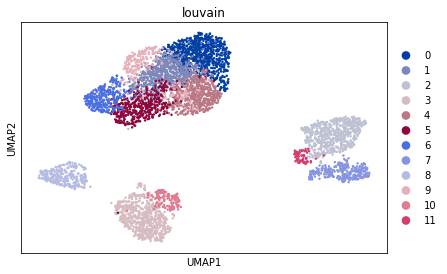

In [12]:
sc.pl.umap(adata, color='louvain');

In [20]:
adata.obsm['X_umap'].dtype

dtype('float64')

In [13]:
adata.obs.head(5)

,louvain
0,2
1,0
2,3
3,4
4,2


### Run louvain clustering algorithm

In [7]:
adata = sc.read_csv('/Users/mincheolkim/Documents/scvi_latent_space.csv')

In [10]:
louvain_clusters = pd.read_csv('/Users/mincheolkim/Documents/scvi_outputs/scvi_louvain/louvain_cluster_labels_14.csv')

In [12]:
louvain_clusters.head(5)

,Unnamed: 0,louvain
0,0,3
1,1,1
2,2,4
3,3,1
4,4,10


In [13]:
adata.obs['louvain'] = louvain_clusters['louvain']

In [20]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=0)

In [172]:
sc.tl.louvain(adata)

### Run UMAP

In [173]:
sc.tl.umap(adata)

### UMAP with new louvain clusters

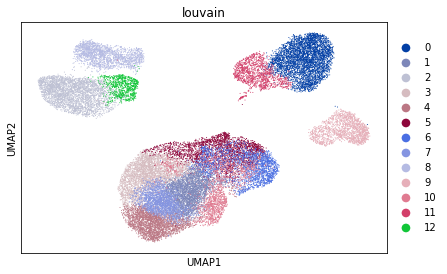

In [174]:
sc.pl.umap(adata, color='louvain');

### tSNE with new louvain clusters

In [ ]:
plt.figure(figsize=(10, 10))
for label in np.unique(louvain_labels):
    plt.scatter(sample_embedded[louvain_labels == label, 0], sample_embedded[louvain_labels == label, 1], s=12)
plt.legend(np.unique(louvain_labels))
plt.xlabel('tSNE1');plt.ylabel('tSNE2');plt.title('tSNE of 5000 sampled cells')

### Visualize 2 latent variable scVI

In [ ]:
plt.figure(figsize=(10, 10))
for label in np.unique(kogene_labels):
    plt.scatter(kogene_embedded[kogene_labels == label, 0], kogene_embedded[kogene_labels == label, 1], s=12)
#plt.legend(np.unique(kogene_labels))
plt.xlabel('tSNE1');plt.ylabel('tSNE2');plt.title('tSNE of 5000 sampled cells (weighted)')

In [ ]:
plt.figure(figsize=(8, 8))
for label in np.unique(batch_indices):
    plt.scatter(latent[batch_indices.ravel() == label, 0], latent[batch_indices.ravel() == label, 1], s=12)
#plt.legend(np.unique(kogene_labels))
plt.xlabel('d1');plt.ylabel('d2');plt.title('Visualization of 5000 sampled cells (by donor)')
plt.legend(np.unique(labels));
plt.savefig('/Users/mincheolkim/Documents/scvi_outputs/labmeeting/scvi_latent_space_donor.png', bbox='tight')

In [ ]:
plt.figure(figsize=(8, 8))
for label in np.unique(labels):
    plt.scatter(latent[labels == label, 0], latent[labels == label, 1], s=0.1)
#plt.legend(np.unique(kogene_labels))
plt.xlabel('d1');plt.ylabel('d2');plt.title('Visualization of 5000 sampled cells')
plt.legend(np.unique(labels));
plt.savefig('/Users/mincheolkim/Documents/scvi_outputs/labmeeting/scvi_latent_space.png', bbox='tight')

### tSNE with Rachel's louvain clusters

In [ ]:
kogene_latent, kogene_batch_indices, kogene_labels = get_cropseq_latent(kogene_model, data_loader['all'])

In [ ]:
kogene_embedded = TSNE(n_components=2).fit_transform(kogene_latent)

In [ ]:
plt.figure(figsize=(10, 10))
for label in np.unique(kogene_labels):
    plt.scatter(kogene_embedded[kogene_labels == label, 0], kogene_embedded[kogene_labels == label, 1], s=12)
#plt.legend(np.unique(kogene_labels))
plt.xlabel('tSNE1');plt.ylabel('tSNE2');plt.title('tSNE of 5000 sampled cells (weighted)')

### Create a meta file with new louvain clusters

In [9]:
h5_filename = data_path + 'raw_gene_bc_matrices_h5.h5'
metadata_filename = data_path + 'nsnp20.raw.sng.km_vb1_default.norm.meta.txt'

In [20]:
scvi_louvain_labels = pd.read_csv('/Users/mincheolkim/Documents/scvi_outputs/scvi_louvain/louvain_cluster_labels_14.csv')['louvain'].values

In [29]:
metadata = pd.read_csv(metadata_filename, sep='\t')
scvi_louvain = metadata.query('guide_cov != "Undetermined"')[['index']]
scvi_louvain['scvi_louvain'] = scvi_louvain_labels
padded_metadata = metadata.merge(scvi_louvain, on='index', how='left')
padded_metadata['scvi_louvain'] = padded_metadata['scvi_louvain'].fillna(-1).astype(int)

In [33]:
len(metadata)

289366

In [32]:
len(padded_metadata)

289366

In [37]:
padded_metadata.to_csv('/Users/mincheolkim/Documents/scvi_outputs/scvi_louvain/nsnp20.raw.sng.km_vb1_default.norm.meta.scvi.txt', index=False)

In [36]:
padded_metadata.query('scvi_louvain < 0')

,index,guide_cov,donor_cov,well_cov,numi_cov,multiplet_cov,nsnp_cov,percent_mito,n_counts,louvain,scvi_louvain
31,GCTCTGTAGGTGGGTT-5,Undetermined,IGTB2065,5,3454,SNG,87,0.044876,1003.69010,0,-1
67,CAACTAGAGCGATAGC-5,Undetermined,IGTB1982,5,4918,SNG,121,0.063034,1457.32640,2,-1
84,TGCTACCAGGCGACAT-2,Undetermined,IGTB1762,2,13024,SNG,309,0.056050,3457.62770,4,-1
145,ACGCAGCAGCGTCAAG-6,Undetermined,IGTB1815,6,4946,SNG,133,0.035584,1541.96260,2,-1
182,GGACATTGTGCGATAG-5,Undetermined,IGTB1372,5,3933,SNG,91,0.069158,1240.39380,3,-1
190,AACTCCCCAACACCTA-16,Undetermined,IGTB1840,16,1961,SNG,60,0.048445,720.65280,1,-1
261,TGGGAAGAGCACGCCT-5,Undetermined,IGTB1762,5,11916,SNG,262,0.047163,3067.68200,4,-1
281,CTGCGGAAGGTGGGTT-1,Undetermined,IGTB1982,1,2909,SNG,43,0.036782,1062.66130,2,-1
333,CCTTCGACACATTCGA-8,Undetermined,IGTB1901,8,4604,SNG,117,0.033666,1603.41350,0,-1
425,GGCGACTCACGAAGCA-1,Undetermined,IGTB884,1,4754,SNG,60,0.040177,1493.87450,3,-1


In [31]:
padded_metadata.head(10)

,index,guide_cov,donor_cov,well_cov,numi_cov,multiplet_cov,nsnp_cov,percent_mito,n_counts,louvain,scvi_louvain
0,CATGGCGAGAACTGTA-9,0,IGTB1815,9,2819,SNG,60,0.021994,971.11430,0,3
1,TGTGTTTTCCAAAGTC-3,0,IGTB508,3,1914,SNG,47,0.033438,736.50040,0,1
2,TACGGATTCTAACTCT-4,RBBP7.16857703.CAGGATTACATTCTCCACTT_guide,IGTB508,4,5436,DBL,163,0.039367,1678.68050,5,4
3,AAGGTTCTCCACTCCA-11,DDX3X.41342522.CGTGGACGGAGTGATTACGA_guide,IGTB884,11,721,SNG,26,0.066574,323.21460,7,1
4,ATTACTCAGCCTATGT-1,ZNF706.101201657.GAAACAAGGACATGACCAAA_guide,IGTB2065,1,5313,DBL,83,0.047431,1741.19170,3,10
5,CCTTCCCGTCACCTAA-8,NFATC3.68183267.ACTGCTGGGTTATGATATGG_guide,IGTB1901,8,2803,SNG,74,0.045309,1125.56620,0,7
6,CTGGTCTAGAAACGCC-3,0,IGTB1815,3,1577,SNG,53,0.038047,673.11640,1,6
7,CGGACGTTCATGCAAC-12,ATF6.161846504.TGAGCCCTGCAAATCAAAGG_guide,IGTB1840,12,2943,SNG,66,0.025144,827.91254,4,5
8,AACTGGTCAAGAAAGG-5,FUS.31184329.CAAAGCTATAATCCCCCTCA_guide,IGTB1982,5,11601,SNG,243,0.041203,3058.07180,4,4
9,ACGGCCACAGCGAACA-15,0,IGTB1840,15,1839,SNG,46,0.044589,644.77560,2,2


In [25]:
scvi_louvain.head(5)

,index,scvi_louvain
0,CATGGCGAGAACTGTA-9,3
1,TGTGTTTTCCAAAGTC-3,1
2,TACGGATTCTAACTCT-4,4
3,AAGGTTCTCCACTCCA-11,1
4,ATTACTCAGCCTATGT-1,10


In [ ]:
metadata['scvi_louvain']temp.query('guide_cov == "Undetermined"').shape

In [11]:
metadata.head(5)

,index,guide_cov,donor_cov,well_cov,numi_cov,multiplet_cov,nsnp_cov,percent_mito,n_counts,louvain
0,CATGGCGAGAACTGTA-9,0,IGTB1815,9,2819,SNG,60,0.021994,971.1143,0
1,TGTGTTTTCCAAAGTC-3,0,IGTB508,3,1914,SNG,47,0.033438,736.5004,0
2,TACGGATTCTAACTCT-4,RBBP7.16857703.CAGGATTACATTCTCCACTT_guide,IGTB508,4,5436,DBL,163,0.039367,1678.6805,5
3,AAGGTTCTCCACTCCA-11,DDX3X.41342522.CGTGGACGGAGTGATTACGA_guide,IGTB884,11,721,SNG,26,0.066574,323.2146,7
4,ATTACTCAGCCTATGT-1,ZNF706.101201657.GAAACAAGGACATGACCAAA_guide,IGTB2065,1,5313,DBL,83,0.047431,1741.1917,3
